In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

# Libraries and Imports

In [2]:
import editdistance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from llms.dna_translator.t5 import DNATranslatorT5
from schemas.train_params import TrainParams

# Params and Files

In [3]:
seed = 12

csv_path = "tran-512.csv"
pretrained_model_name = "DNATranT5"

In [4]:
csv_path = f"./storage/data/processed/{csv_path}"
output_path = f"./storage/models/tuned/{pretrained_model_name}"
checkpoint = "./storage/models/base/t5"

# Reading Dataset

In [5]:
df = pd.read_csv(csv_path, keep_default_na=False)

# Loading Model

In [6]:
llm = DNATranslatorT5(
  checkpoint=checkpoint,
  seed=seed
)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


# Data Processing

In [7]:
data = df.to_dict(orient="records")

In [8]:
all_dataset = []
for record in tqdm(data):
  example = llm.build_input(
    dna=record["sequence"],
    organism=record["organism"],
    protein=record["target"]
	)
  all_dataset.append(example)

train_dataset, test_dataset = train_test_split(
  all_dataset,
  test_size=0.05,
  random_state=seed,
  shuffle=True
)

100%|██████████| 66798/66798 [00:00<00:00, 1892344.86it/s]


# Data Analysis

In [9]:
print("Train Dataset Len:", len(train_dataset))
print("Test Dataset Len:", len(test_dataset))

Train Dataset Len: 63458
Test Dataset Len: 3340


In [10]:
train_lengths = [len(example["dna"]) for example in train_dataset]
test_lengths = [len(example["dna"]) for example in test_dataset]

Train Dataset Len: 63458
Test Dataset Len: 3340


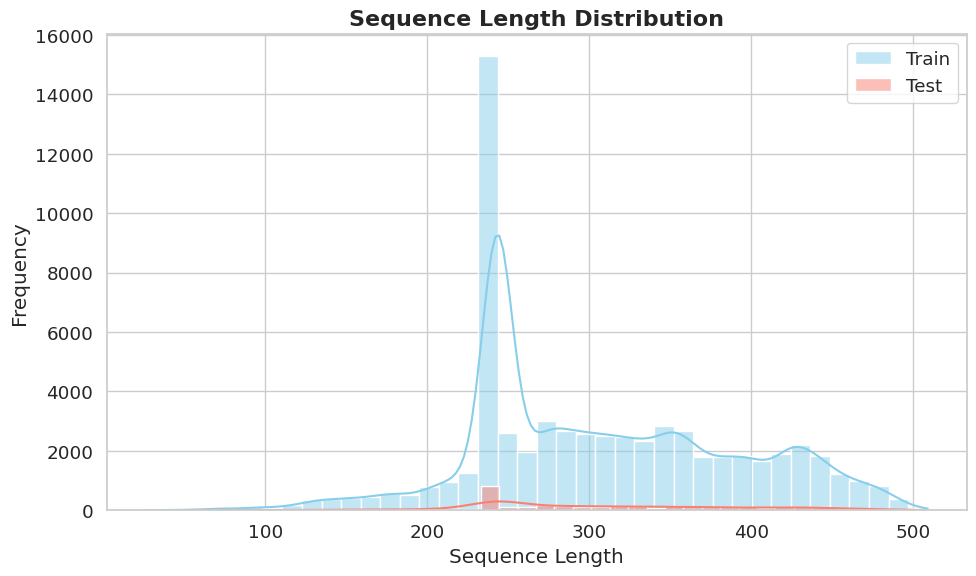

In [11]:
print("Train Dataset Len:", len(train_dataset))
print("Test Dataset Len:", len(test_dataset))

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

plt.figure(figsize=(10, 6))
sns.histplot(train_lengths, kde=True, bins=40, color="skyblue", label="Train")
sns.histplot(test_lengths, kde=True, bins=40, color="salmon", label="Test")

plt.title("Sequence Length Distribution", fontsize=16, weight="bold")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Training

In [16]:
llm.train(
  dataset=train_dataset,
  params=TrainParams(
    epochs=3,
    batch_size=16,
    gradient_accumulation=1,
    lr=3e-6,
    logging_steps=1000
	)
)

2025-11-11 12:36:28,799 - INFO - Preparing dataset...
100%|██████████| 63458/63458 [01:04<00:00, 984.75it/s] 
2025-11-11 12:37:37,054 - INFO - Dataset prepared!
2025-11-11 12:37:37,529 - INFO - Starting training...
/home-lib/gustavo.cruz/miniconda3/envs/dna/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
1000,4.203000
2000,4.170500
3000,4.146600
4000,4.129600
5000,4.121500


2025-11-11 13:03:33,915 - INFO - Training complete. You may save the model for later usage.


# Saving The Model

In [13]:
llm.save_pretrained(output_path)

2025-11-11 11:41:27,697 - INFO - Attempting to save model at './storage/models/tuned/DNATranT5'
2025-11-11 11:41:36,187 - INFO - Successfully saved at './storage/models/tuned/DNATranT5'


# Test Without Blast

In [17]:
results = []

for data in tqdm(test_dataset):
	pred = llm.generate(data)
	target = data["protein"]

	dist = editdistance.eval(pred, target)
	similarity = 1 - dist / max(len(pred), len(target))

	#blast_results = blast_analysis(
	#	pred=pred,
	#	target=target
	#)

	results.append({
		"target": target,
		"pred": pred,
		"edit_dist": dist,
		"similarity": similarity,
		#**blast_results
	})

100%|██████████| 3340/3340 [13:43<00:00,  4.05it/s]


In [18]:
similarities = [r["similarity"] for r in results]
mean_similarity = np.mean(similarities)
std_similarity = np.std(similarities)

print(f"Mean similarity: {mean_similarity:.4f} ± {std_similarity:.4f}")

df = pd.DataFrame(results)
df["length"] = df["target"].apply(len)

print(df.groupby(pd.cut(df["length"], bins=[0,50,100,200,400]), observed=False)["similarity"].mean())

Mean similarity: 0.0734 ± 0.0394
length
(0, 50]       0.041338
(50, 100]     0.097348
(100, 200]    0.121918
(200, 400]         NaN
Name: similarity, dtype: float64
